# PseudoRHI (Xradar and Pyart)

- Author: Hamid Ali Syed
- Purpose: For Khairunnisa
- Date: Nov 1, 2023

In [1]:
import os
import pyart
import xradar
import cmweather
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file1 = "2021110312350500dBZ.vol"
dtree = xradar.io.open_rainbow_datatree(file1)

In [4]:
# Fubction to add necessaey metadata, in order to export it to cfradial1 format
def correct_cfradial2(dtree):
    data = np.array('axis_z', dtype='|S32')
    attributes = {
        'standard_name': 'primary_axis_of_rotation',
        'options': 'axis_z, axis_y, axis_x'
    }
    # Create the xarray DataArray
    dtree['primary_axis'] = xr.DataArray(data, attrs=attributes, dims=())
    
    fixed_angles = []
    for grp in dtree.groups:
        if "sweep" in grp:
            fixed_angle = dtree[grp]['sweep_fixed_angle'].values
            fixed_angles.append(fixed_angle)
            dtree[grp]['sweep_mode'] = xr.DataArray(
                np.array(dtree[grp]['sweep_mode'], dtype='|S32'),
                attrs={'standard_name': 'scan_mode_for_sweep',
     'options': 'sector, coplane, rhi, vertical_pointing, idle, azimuth_surveillance, \
     elevation_surveillance, sunscan, pointing, calibration, manual_ppi, manual_rhi'})
    
    fixed_angles = np.array(fixed_angles, dtype=np.float32)
    sweep_groups = np.array([f'sweep_{i}' for i in range(fixed_angles.size)])
    dtree['sweep_fixed_angle'] = xr.DataArray(fixed_angles, dims=('sweep'))
    dtree['sweep_group_name'] = xr.DataArray(sweep_groups, dims=('sweep'))
    dtree['volume_number'] = xr.DataArray(np.array(0, dtype=np.int16),
                                      attrs={'standard_name':'data_volume_index_number'})
    dtree['instrument_type'] = xr.DataArray(np.array('radar', dtype='|S32'),
                                      attrs={'standard_name': 'type_of_instrument',
                                             'options': 'radar, lidar',
                                             'meta_group': 'instrument_parameters'}
                                       )
    dtree['platform_type'] = xr.DataArray(
        np.array('fixed', dtype='|S32'),
        attrs={'standard_name': 'platform_type',
    'options':'fixed, vehicle, ship, aircraft_fore, aircraft_aft, aircraft_tail, aircraft_belly,\
    aircraft_roof, aircraft_nose, satellite_orbit, satellite_geostat'})
    
    return dtree

In [5]:
# Apply Correction
dtree = correct_cfradial2(dtree)

# Export to Cfradial1
xradar.io.to_cfradial1(dtree, filename=None, calibs=True)

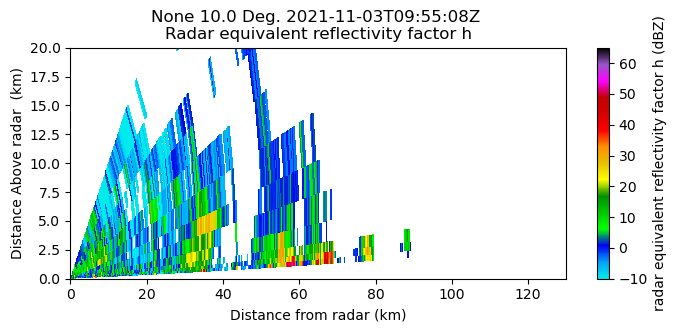

In [6]:
# Now Let's create PsedudoRHI using Pyart
radar = pyart.io.read_cfradial('cfrad1_None_20211103_095505.nc')
azi = 10 # Choose any azimuth from 0 to 360
pseudorhi = pyart.util.cross_section_ppi(radar, [azi])
display = pyart.graph.RadarDisplay(pseudorhi)
fig = plt.figure(figsize=[8, 3])
ax = plt.axes()
display.plot_rhi('DBZH', ax=ax, cmap="NWSRef")
ax.set_ylim(0, 20)
ax.set_xlim(0,130)
plt.show()

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_map(ax, b = 0, t=0, l = 0, r = 0):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.3, 
                         linestyle='-', draw_labels=True)
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right=r
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(feat.BORDERS, lw = 0.5)
    ax.add_feature(feat.STATES.with_scale("10m"), alpha = 0.5, lw = 0.4, ls=":")

output_dir = "azimuth_ppi_rhi"
os.makedirs(output_dir, exist_ok=True)
projection=ccrs.LambertAzimuthalEqualArea(radar.longitude['data'][0],
                                          radar.latitude['data'][0]
                                         )
pdisplay = pyart.graph.RadarMapDisplay(radar)

for i in range(0, 361, 20):
    azi = find_nearest(radar.azimuth['data'][radar.get_slice(0)], i)
#     print(f"Plotting azimuth {azi}")
    pseudorhi = pyart.util.cross_section_ppi(radar, [azi])
    display = pyart.graph.RadarDisplay(pseudorhi)
    fig = plt.figure(figsize=[12, 6])

    map_panel_axes = [0.01, 0.05, .5, .7]
    x_cut_panel_axes = [0.5, 0.05, .5, .7]

    # Panel 1: PPI plot of the second tilt.
    ax1 = fig.add_axes(map_panel_axes, projection=projection)
    pdisplay.plot_ppi_map("DBZH", sweep=1, cmap = "ChaseSpectral",
                          resolution="50m", fig=fig, ax=ax1, projection=projection)
    pdisplay.plot_range_rings(np.linspace(50, 130, 3), lw = 0.5, ax=ax1)

    radar_lat = radar.latitude['data']
    radar_lon = radar.longitude['data']

    # Create azimuth lines
    dtor = np.pi/180.0
    max_range = radar.range['data'].max()/1e3
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * np.cos(radar_lat * dtor))

    # for azi in range(0,360,45): # 45 degree intervals
    azimuth = 90. - azi
    dazimuth = azimuth * dtor
    lon_maxrange = radar_lon + np.cos(dazimuth) * meters_to_lon * maxrange_meters
    lat_maxrange = radar_lat + np.sin(dazimuth) * meters_to_lat * maxrange_meters
    pdisplay.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange], line_style='-', 
                           lw=2, color='yellow', transform=ccrs.PlateCarree())
    add_map(ax=ax1, b=1, l=1)
    # Panel 2: RHI slice
    ax2 = fig.add_axes(x_cut_panel_axes)
    display.plot_rhi('DBZH', ax = ax2, cmap = "pyart_NWSRef")
    ax2.set_ylim([0,20])
    ax2.set_xlim([0,130])
    plt.savefig(f"{output_dir}{os.sep}{i}_RHI_Tauktae_azimuth_{azi}"+".png", bbox_inches="tight")
    plt.close()

In [9]:
# !open $output_dir

In [10]:
import re
def natural_sort_key(s, _re=re.compile(r'(\d+)')):
    return [int(t) if i & 1 else t.lower() for i, t in enumerate(_re.split(s))]

In [11]:
import glob
from PIL import Image

# filepaths
fp_in = f"{output_dir}{os.sep}*png"
fp_out = 'knisa_vol.gif'
files = sorted(glob.glob(fp_in))
sorted_files = sorted(files, key=natural_sort_key)
img, *imgs = [Image.open(f) for f in sorted_files]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=300, loop=0)

In [12]:
from IPython.display import Image
Image(url='knisa_vol.gif') 